# Кейс №1 - Приложение знакомств

## Описание задачи

Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать одну или несколько метрик, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат вашей работы – *аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.*

## Загрузка данных и библиотек

In [1]:
# избавляемся от ворнингов о том, что используются старые версии пакетов
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# stats 
# from scipy import stats
import scipy.stats as stats
import pingouin as pg

In [3]:
df = pd.read_csv('dating_data.csv')

df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


## Краткий EDA

In [4]:
df.shape

(14514, 4)

In [5]:
df.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

In [6]:
df.isnull().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [7]:
df.describe()

,user_id_1,user_id_2,group,is_match
count,14514.000000,14514.000000,14514.000000,14514.000000
mean,500.220132,501.843737,0.669836,0.333678
std,288.703825,287.250879,0.470288,0.471542
min,1.000000,1.000000,0.000000,0.000000
25%,253.000000,255.000000,0.000000,0.000000
50%,504.000000,500.000000,1.000000,0.000000
75%,751.000000,752.750000,1.000000,1.000000
max,1000.000000,1000.000000,1.000000,1.000000


Видим, что строк приблизительно в 14.5 раз больше (вспоминаем шейп), чем пользователей - уникальных значений в колонках user_id ровно 1000, с максимальным значением в 1000, минимальный - 1. 

Можно предположить, что некоторые user_id попали в выборку больше 1 раза (больше 1 раза зашли в приложение и сделали свайп вправо/влево)
Соответственно, в будущем можно будет сгруппироваться по user_id и подсчитать для каждого процент удачного свайпа (мэтча)

### Проверяем возможные проблемы в системе сплитования 

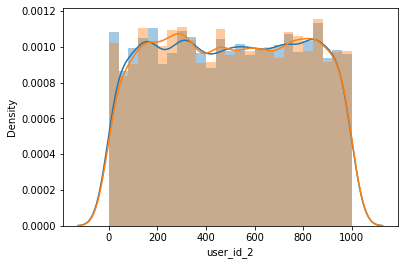

In [8]:
sns.distplot(df.user_id_1)
sns.distplot(df.user_id_2)

In [9]:
df.query('group == 0').shape[0] 

4792

In [10]:
df.query('group == 1').shape[0]

9722

Алярм! Возможно, система сплитования не сработала лучшим образом. Давайте проверим:

In [11]:
df.query('group == 0').user_id_1.nunique() - df.query('group == 1').user_id_1.nunique()

2

In [12]:
df.query('group == 0').user_id_2.nunique() - df.query('group == 1').user_id_2.nunique()

2

Нет, все хорошо, группы отлично поделились. Если УЖЕ принимать во внимание альтернативную гипотезу о том что алгоритм сработал более качественно, и тестовая группа действительно получает больше матчей => возможно, как следствие, люди из данной группы в целом больше проводят "раундов" в приложении

## Разбиение выборок, выбор метрики

Нас просят проверить алгоритм для поиска наиболее подходящих анкет. Соответственно, цель такого изменения - повысить относительное количество мэтчей, процент успешных мэтчей. 

Я предлагаю сначала посчитать процент успешных матчей от всех для этой группы (is_match == 1 / count(is_match)

In [13]:
round(df.query('group == 0 & is_match == 1').shape[0] / df.query('group == 0').shape[0], 3)

0.195

In [14]:
round(df.query('group == 1 & is_match == 1').shape[0] / df.query('group == 1').shape[0], 3)

0.402

Итак, в целом заметно, что в группе 1 (тестовой) происходит больше успешных свайпов. Но это только общая картина и этому могут быть разные объяснения. Например то, что в одной группе больше пользователей которые вообще ни разу не мэтчнулись (но провели достаточное количество раундов свайпа) и руинят всю нашу идеальную картину восприятия данных

Надо посмотреть на каждого пользователя по отдельности.

In [15]:
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


Выводя уникальное значение user_id_2 для юзеров из user_id_1 можем посчитать, сколько "раундов" у них было

In [16]:
df.groupby('user_id_1', as_index = False).agg({'user_id_2': 'nunique'}).sort_values('user_id_2', ascending = True)

,user_id_1,user_id_2
435,436,1
29,30,2
903,904,2
920,921,3
128,129,3
...,...,...
607,608,26
197,198,27
37,38,28
826,827,28


In [17]:
df.groupby('user_id_2', as_index = False).agg({'user_id_1': 'nunique'}).sort_values('user_id_1', ascending = True)

,user_id_2,user_id_1
26,27,3
882,883,3
499,500,4
552,553,4
334,335,4
...,...,...
313,314,31
980,981,32
786,787,33
715,716,34


Из-за того, что у двух групп user_id разное количество "раундов" (где пользователь мог поставить лайк или дизлайк) нельзя говорить о том, что данные дублируют друг друга

### Подсчет метрики для юзеров_1

Наконец-то, мы можем посчитать процент успешных "раундов" для юзеров_1, что и будет нашей метрикой, по которым мы мерим успешность А-Б эксперимента. 
Также я буду считать их для юзеров_2, но позже. После этого и сделаю выводы

In [18]:
user_1_matches = df \
    .groupby('user_id_1', as_index = False) \
    .agg({'is_match': 'sum', 'user_id_2': 'nunique'}) \
    .rename(columns = {'is_match' : 'total_matches', 'user_id_2': 'total_attempts'})

user_1_matches

,user_id_1,total_matches,total_attempts
0,1,11,24
1,2,7,16
2,3,5,16
3,4,2,9
4,5,13,22
...,...,...,...
995,996,1,8
996,997,1,12
997,998,10,18
998,999,2,7


In [19]:
user_1_matches['success_prc'] = user_1_matches.total_matches / user_1_matches.total_attempts

user_1_matches

# не буду округлять чтобы не терять точность при дальнейших вычислениях

,user_id_1,total_matches,total_attempts,success_prc
0,1,11,24,0.458333
1,2,7,16,0.437500
2,3,5,16,0.312500
3,4,2,9,0.222222
4,5,13,22,0.590909
...,...,...,...,...
995,996,1,8,0.125000
996,997,1,12,0.083333
997,998,10,18,0.555556
998,999,2,7,0.285714


## Сравнение контрольной и тестовой группы для процента успеха юзеров_1 

Присоединяем эту метрику к основному датафрейму, дабы потом отобрать юзеров по тестовой и контрольной группе эксперимента

In [20]:
user1_group = df.merge(user_1_matches, how ='left', on = 'user_id_1')

user1_group.head()

,user_id_1,user_id_2,group,is_match,total_matches,total_attempts,success_prc
0,79,91,1,1,4,11,0.363636
1,716,353,1,1,9,20,0.450000
2,423,677,0,0,1,12,0.083333
3,658,165,1,1,13,18,0.722222
4,969,155,0,1,5,11,0.454545


In [21]:
user1_group.shape

(14514, 7)

In [22]:
# Уберем дубликаты user_id_1, оставив только оригинальные значения

user1_group = user1_group.drop_duplicates(subset=['user_id_1'])

user1_group.shape

(1000, 7)

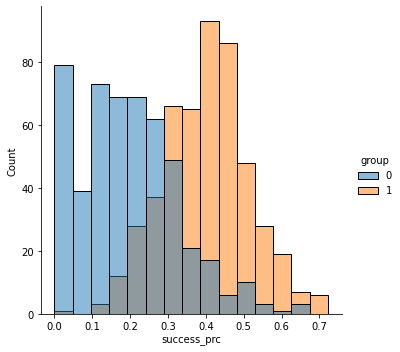

In [23]:
sns.displot(data = user1_group, x = 'success_prc', hue = 'group')

Видно, что для тестовой группы процент успеха в мэтчах вырос. Осталось проверить стат. значимость

### Стат.тест

Я проверю, различается ли среднее значение успеха для контрольной и тестовой группы юзеров 1. Для этого нужно использовать ттест в случае если переменные нормально распределены

In [24]:
test = user1_group.loc[user1_group.group == 0, 'success_prc']
control = user1_group.loc[user1_group.group == 1, 'success_prc']

print(test.head(), control.head())

2     0.083333
4     0.454545
5     0.200000
8     0.307692
10    0.000000
Name: success_prc, dtype: float64 0    0.363636
1    0.450000
3    0.722222
6    0.368421
7    0.333333
Name: success_prc, dtype: float64


In [25]:
stats.normaltest(test)

NormaltestResult(statistic=24.051421842755083, pvalue=5.988252519460086e-06)

In [26]:
stats.normaltest(control)

NormaltestResult(statistic=0.27389179572110844, pvalue=0.8720174028630457)

Не можем отклонить нулевую гипотезу о ненормальности распределений в тестовой группе, приступаем к стат.тесту

In [27]:
stats.ttest_ind(test, control)

Ttest_indResult(statistic=-26.41850375281793, pvalue=4.842755754030156e-117)

In [28]:
round((test.mean() - control.mean()) / control.mean() * 100, 2)

# отличие аж на 51.76 процентный пункт!

-51.76

pvalue чрезвычайно низкое: значит, мы отклоняем нулевую гипотезу о равенстве средних и говорим, что основываясь на предоставленных данных, среднее значение успешных "раундов" действительно отличается в контрольной и тестовой группе 

## Рассчет метрики для юзеров_2

Итак, для юзеров_1 это мы проверили. Что для юзеров_2? Проведем точно такую же операцию!

In [29]:
user_2_matches = df \
    .groupby('user_id_2', as_index = False) \
    .agg({'is_match': 'sum', 'user_id_1': 'nunique'}) \
    .rename(columns = {'is_match' : 'total_matches', 'user_id_1': 'total_attempts'})

user_2_matches

,user_id_2,total_matches,total_attempts
0,1,5,13
1,2,9,23
2,3,3,9
3,4,1,8
4,5,5,12
...,...,...,...
995,996,1,6
996,997,0,14
997,998,8,18
998,999,1,13


In [30]:
user_2_matches['success_prc'] = user_2_matches.total_matches / user_2_matches.total_attempts

user_2_matches
# не буду округлять чтобы не терять точность при дальнейших вычислениях

,user_id_2,total_matches,total_attempts,success_prc
0,1,5,13,0.384615
1,2,9,23,0.391304
2,3,3,9,0.333333
3,4,1,8,0.125000
4,5,5,12,0.416667
...,...,...,...,...
995,996,1,6,0.166667
996,997,0,14,0.000000
997,998,8,18,0.444444
998,999,1,13,0.076923


## Сравнение контрольной и тестовой группы для процента успеха юзеров_1 

In [31]:
user2_group = df.merge(user_2_matches, how ='left', on = 'user_id_2')

user2_group.head()

,user_id_1,user_id_2,group,is_match,total_matches,total_attempts,success_prc
0,79,91,1,1,9,20,0.450000
1,716,353,1,1,8,21,0.380952
2,423,677,0,0,1,7,0.142857
3,658,165,1,1,14,23,0.608696
4,969,155,0,1,3,11,0.272727


In [32]:
# Уберем дубликаты user_id_1, оставив только оригинальные значения

user2_group = user2_group.drop_duplicates(subset=['user_id_1'])

user2_group.shape

(1000, 7)

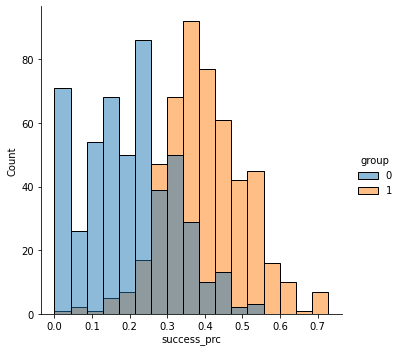

In [33]:
sns.displot(data = user2_group, x = 'success_prc', hue = 'group')

Пока тенденция ровно такая же, что и для юзеров_1!

In [34]:
test = user2_group.loc[user2_group.group == 0, 'success_prc']
control = user2_group.loc[user2_group.group == 1, 'success_prc']

print(test.head(), control.head())

2     0.142857
4     0.272727
5     0.000000
8     0.083333
10    0.000000
Name: success_prc, dtype: float64 0    0.450000
1    0.380952
3    0.608696
6    0.050000
7    0.538462
Name: success_prc, dtype: float64


### Стат.тест

In [35]:
stats.normaltest(test)

NormaltestResult(statistic=7.4584020610463675, pvalue=0.024012013040184927)

In [36]:
stats.normaltest(control)

NormaltestResult(statistic=8.77170607565921, pvalue=0.012452261352455812)

Увы, но данный тест показывает, что нулевая гипотеза о нормальном распределении не подтверждается на данных. Проверим другим стат.тестом:

In [37]:
print('pvalue тестовой группы =', round(stats.shapiro(test)[1], 5),
                                         'pvalue контрольной группы =', round(stats.shapiro(control)[1], 5))
# проверяем менее жестким тестом shapiro

pvalue тестовой группы = 0.0 pvalue контрольной группы = 0.00045


Тут то же самое. Смотрим на графики распределений:

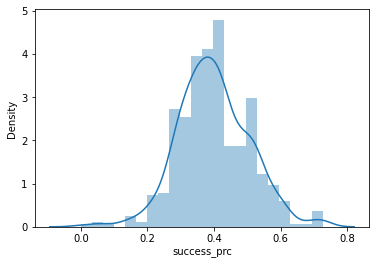

In [38]:
sns.distplot(user2_group[user2_group.group == 1].success_prc)

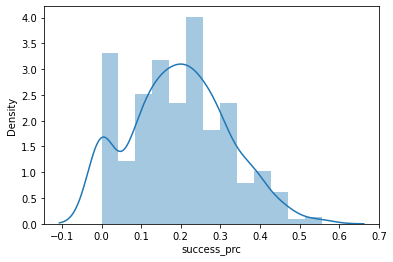

In [39]:
sns.distplot(user2_group[user2_group.group == 0].success_prc)

Судя по графику, я бы не сказал, что данные суперненормально распределены. Доверяю цифрам, провожу непараметрический тест Манна-Уитней, и следом тест Стьюдента просто на проверку: если они оба покажут одинаковый стат. значимый результат, можно будет говорить о том, что именно средние отличаются, а не "ранки"

In [40]:
stats.mannwhitneyu(test, control)

MannwhitneyuResult(statistic=26419.0, pvalue=1.9600738343776863e-103)

In [41]:
stats.ttest_ind(test, control)

Ttest_indResult(statistic=-27.84722770304672, pvalue=9.651896670809947e-127)

In [42]:
round((test.mean() - control.mean()) / control.mean() * 100, 2)

-51.01

Оба теста показывают показывают pvalue < 0.05 (да и даже меньше 0.01, но мы решили, что порог значимости именно 0.05). 

Значит, мы отклоняем нулевую гипотезу о равенстве средних и говорим, что основываясь на предоставленных данных, среднее значение успешных "раундов" действительно отличается в контрольной и тестовой группе. Перейдем к выводам!

## Финальные выводы

Вывод: можно было дальнейшим образом эксперементировать с данными - создать какую-то уникальную метрику высчитывающую проценты удачных пар, а не для каждого юзера. Можно было исключить юзеров с малым количеством "раундов", тк изменения ярче всего проявляются на когорте пользователей с большим количеством попыток мэтча. 

Но я решил не мудрить и обосновать свое решение на одной метрике для двух, по сути, разных (я проверял, не являются ли раунды двух групп пользователей user_1 и user_2 зеркальными и дублирующими друг друга когда смотрел уникальные значения для user_1 и user_2) групп пользователей. И дважды я нашел стат. значимую различимость в средних значениях процентов успешных "раундов" - и оба раза в сторону тестовой группы.

Принимая во внимание также общий процент успешных мэтчей для каждой из контрольно/тестовых групп (да даже если не принимая), я делаю однозначный вывод о том, что **стоит включать новую систему поиска анкет на всех пользователей**, если наша цель состоит в том, чтобы повысить количество мэтчей для всех юзеров.

Другое дело, что в дэйтинговых сервисах не менее важен и пол пользователей (для того чтобы лучше крутить монетизацию), да и еще куча всяких бизнесовых фишек. Но имея именно такие условия задачи и данные, я отвечаю положительно.
